# Notebook 1 AnaliseSentimentosBagOfWord - Alunos Regulares IA024-2024S1 FEEC-

**Nome:** Caio Petrucci dos Santos Rosa

**RA:** 248245

## Instalação e importação de pacotes

In [ ]:
!pip install torchtext
!pip install 'portalocker>=2.0.0'
!pip install Unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 6.3 MB/s eta 0:00:00


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchtext.datasets import IMDB
from collections import Counter
import torch.nn as nn
import torch.optim as optim

## I - Vocabulário e Tokenização

In [ ]:
# limit the vocabulary size to 20000 most frequent tokens
vocab_size = 20000

counter = Counter()
for (target, line) in list(IMDB(split='train')):
    counter.update(line.split())

# create a vocabulary of the 20000 most frequent tokens
most_frequent_words = sorted(counter, key=counter.get, reverse=True)[:vocab_size]
vocab = {word: i for i, word in enumerate(most_frequent_words, 1)}
vocab_size = len(vocab)

In [ ]:
def encode_sentence(sentence, vocab):
    return [vocab.get(word, 0) for word in sentence.split()] # 0 for OOV

encode_sentence("I like Pizza.", vocab)

[8, 35, 0]

### Exercício 1

#### Exercício 1. a)

In [ ]:
# limit the vocabulary size to 20000 most frequent tokens
vocab_size = 20000

# define label mapping from integer values to string
labels = {1: "negative", 2: "positive"}

# start all counters
counter = Counter()
sentiment_counter = Counter()
total_reviews, total_words = (0, 0)

for (target, line) in list(IMDB(split='train')):
    counter.update(line.split())
    sentiment_counter.update([labels[target]])
    total_words += len(line.split())
    total_reviews += 1

# create a vocabulary of the 20000 most frequent tokens
most_frequent_words = sorted(counter, key=counter.get, reverse=True)[:vocab_size]
vocab = {word: i for i, word in enumerate(most_frequent_words, 1)} # words indexed from 1 to 20000
vocab_size = len(vocab)

# calculate the average amount of words per review
avg_words_per_review = total_words/total_reviews

#### Exercício 1. b)

In [ ]:
print(f"There are {sentiment_counter['negative']} negatives reviews in the training dataset.")
print(f"There are {sentiment_counter['positive']} positives reviews in the training dataset.")
print(f"There are {sentiment_counter.total()} reviews in the training dataset.")

There are 12500 negatives reviews in the training dataset.
There are 12500 positives reviews in the training dataset.
There are 25000 reviews in the training dataset.


#### Exercício 1. c)

In [ ]:
print(f"Average amount of words per review: {avg_words_per_review}")

Average amount of words per review: 233.7872


### Exercício 2

#### Exercício 2. a)

In [ ]:
print(f"The 5 most frequent words in the are: {', '.join(most_frequent_words[:5])}.")
print(f"The 5 least frequent words in the vocabulary are: {', '.join(most_frequent_words[-5:])}.")

The 5 most frequent words in the are: the, a, and, of, to.
The 5 least frequent words in the vocabulary are: age-old, place!, Bros, tossing, nation,.


#### Exercício 2. c)

In [ ]:
# amount of tokens not covered in vocabulary
unknown_tokens = len(counter.items()) - vocab_size

print(f"Amount of unknown (by the vocabulary) tokens in training dataset: {unknown_tokens}")

Amount of unknown (by the vocabulary) tokens in training dataset: 260617


### Exercício 3


#### Exercício 3. a)

In [ ]:
# define label mapping from integer values to string
labels = {1: "negative", 2: "positive"}

train_sentiment_counter = Counter()
for (target, line) in list(IMDB(split='train'))[:200]:
    train_sentiment_counter.update([labels[target]])

test_sentiment_counter = Counter()
for (target, line) in list(IMDB(split='test'))[:200]:
    test_sentiment_counter.update([labels[target]])

print(f"There are {train_sentiment_counter['negative']} negatives reviews in the first 200 samples of training dataset.")
print(f"There are {train_sentiment_counter['positive']} positives reviews in the first 200 samples of training dataset.")
print(f"There are {train_sentiment_counter.total()} reviews in the first 200 samples of training dataset.")
print()
print(f"There are {test_sentiment_counter['negative']} negatives reviews in the first 200 samples of testing dataset.")
print(f"There are {test_sentiment_counter['positive']} positives reviews in the first 200 samples of testing dataset.")
print(f"There are {test_sentiment_counter.total()} reviews in the first 200 samples of testing dataset.")

There are 200 negatives reviews in the first 200 samples of training dataset.
There are 0 positives reviews in the first 200 samples of training dataset.
There are 200 reviews in the first 200 samples of training dataset.

There are 200 negatives reviews in the first 200 samples of testing dataset.
There are 0 positives reviews in the first 200 samples of testing dataset.
There are 200 reviews in the first 200 samples of testing dataset.


#### Exercício 3. b)

In [ ]:
# limit the vocabulary size to 20000 most frequent tokens
vocab_size = 20000

# define label mapping from integer values to string
labels = {1: "negative", 2: "positive"}

all_train_data = list(IMDB(split='train'))
balanced_train_data_200 = list(filter(lambda sample: sample[0]==1, all_train_data))[:100] + list(filter(lambda sample: sample[0]==2, all_train_data))[:100]

counter = Counter()
sentiment_counter = Counter()
for (target, line) in balanced_train_data_200:
    counter.update(line.split())
    sentiment_counter.update([labels[target]])

# create a vocabulary of the 20000 most frequent tokens
most_frequent_words = sorted(counter, key=counter.get, reverse=True)[:vocab_size]
vocab = {word: i for i, word in enumerate(most_frequent_words, 1)}
vocab_size = len(vocab)

print(f"There are {sentiment_counter['negative']} negatives reviews in the first 200 balanced samples from the training dataset.")
print(f"There are {sentiment_counter['positive']} positives reviews in the first 200 balanced samples from the training dataset.")

There are 100 negatives reviews in the first 200 balanced samples from the training dataset.
There are 100 positives reviews in the first 200 balanced samples from the training dataset.


## II - Dataset

In [ ]:
from torch.nn.functional import one_hot
# Dataset Class with One-hot Encoding
class IMDBDataset(Dataset):
    def __init__(self, split, vocab):
        self.data = list(IMDB(split=split))
        self.vocab = vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        target, line = self.data[idx]
        target = 1 if target == 1 else 0

        # one-hot encoding
        X = torch.zeros(len(self.vocab) + 1)
        for word in encode_sentence(line, self.vocab):
            X[word] = 1

        return X, torch.tensor(target)

# Load Data with One-hot Encoding
train_data = IMDBDataset('train', vocab)
test_data = IMDBDataset('test', vocab)

### Exercício 1

#### Exercício 1. a)

In [ ]:
# define label mapping from integer values to string
labels = {1: "negative", 0: "positive"}

# count labels (considering one-hot encoding)
label_counter = Counter()
for input, label in train_data:
    label_counter.update([labels[label.item()]])

print(f"There are {label_counter['negative']} negative labels in the dataset.")
print(f"There are {label_counter['positive']} positive labels in the training dataset.")
print(f"There are {label_counter.total()} samples in the dataset.")

There are 12500 negative labels in the dataset.
There are 12500 positive labels in the training dataset.
There are 25000 samples in the dataset.


#### Exercício 1. b)

In [ ]:
from torch import sum as tensor_sum

# count average amount of words per sample (considering one-hot encoding)
total_samples, total_words_one_hot = (0, 0)

for input, label in train_data:
    total_words_one_hot += tensor_sum(input).item()
    total_samples += 1

avg_word_per_one_hot = total_words_one_hot/total_samples
print(f"Average amount of words per sample encoded as one-hot vector: {avg_word_per_one_hot}")

Average amount of words per sample encoded as one-hot vector: 111.81108


### Exercício 2

#### Exercício 2. a)

In [ ]:
from torch.nn.functional import one_hot
# Dataset Class with One-hot Encoding
class UnoptimizedIMDBDataset(Dataset):
    def __init__(self, split, vocab):
        self.data = list(IMDB(split=split))
        self.vocab = vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        target, line = self.data[idx]
        target = 1 if target == 1 else 0

        # one-hot encoding
        X = torch.zeros(len(self.vocab) + 1)
        for word in encode_sentence(line, self.vocab):
            X[word] = 1

        return X, torch.tensor(target)

# Load unoptimized dataset
unoptimized_train_data = UnoptimizedIMDBDataset('train', vocab)
unoptimized_test_data = UnoptimizedIMDBDataset('test', vocab)

# Define batch size
batch_size = 128

# Define dataloaders based on unoptimized datasets
unoptimized_train_loader = DataLoader(unoptimized_train_data, batch_size=batch_size, shuffle=True)
unoptimized_test_loader = DataLoader(unoptimized_test_data, batch_size=batch_size, shuffle=False)

In [ ]:
import time

class OneHotMLP(nn.Module):
    def __init__(self, vocab_size):
        super(OneHotMLP, self).__init__()

        self.fc1 = nn.Linear(vocab_size+1, 200)
        self.fc2 = nn.Linear(200, 1)

        self.relu = nn.ReLU()

    def forward(self, x):
        o = self.fc1(x.float())
        o = self.relu(o)
        return self.fc2(o)

# Verifica se há uma GPU disponível e define o dispositivo para GPU se possível, caso contrário, usa a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print('GPU:', torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print('using CPU')

# Model instantiation
model = OneHotMLP(vocab_size).to(device)

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Training loop
iter_counter, total_duration, forward_duration, backward_duration = [0, 0, 0, 0]
total_start_time = time.time()  # Start time of two iterations

model.train()
for inputs, targets in unoptimized_train_loader:
    if (iter_counter >= 2):
        break
    # Forward pass
    forward_start_time = time.time()

    inputs = inputs.to(device)
    targets = targets.to(device)

    logits = model(inputs)
    loss = criterion(logits.squeeze(), targets.float())

    forward_end_time = time.time()
    forward_duration += forward_end_time - forward_start_time

    # Backward and optimize
    backward_start_time = time.time()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    backward_end_time = time.time()
    backward_duration += backward_end_time - backward_start_time

    iter_counter += 1

total_end_time = time.time()  # End time of two iterations
total_duration = total_end_time - total_start_time  # Duration of two iteration

print('Elapsed Time After 2 Unoptimized Iterations:')
print(f'\tTotal: {total_duration:.4f} sec')
print(f'\tForward pass: {forward_duration:.4f} sec')
print(f'\tBackward pass: {backward_duration:.4f} sec')

GPU: Tesla T4
Elapsed Time After 2 Unoptimized Iterations:
	Total: 1.0930 sec
	Forward pass: 0.4538 sec
	Backward pass: 0.1968 sec


#### Exercício 2. b)

In [ ]:
from torch.nn.functional import one_hot
# Dataset Class with One-hot Encoding
class IMDBDataset(Dataset):
    def __init__(self, split, vocab):
        self.raw_data = list(IMDB(split=split))
        self.vocab = vocab
        self.data = [ self.__encode_sample_to_onehot(sample) for sample in self.raw_data ]

    def __encode_sample_to_onehot(self, sample):
        target, line = sample
        target = 1 if target == 1 else 0
        # one-hot encoding
        X = torch.zeros(len(self.vocab) + 1)
        for word in encode_sentence(line, self.vocab):
            X[word] = 1
        return X, torch.tensor(target)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Load Data with One-hot Encoding
train_data = IMDBDataset('train', vocab)
test_data = IMDBDataset('test', vocab)

# Define batch size
batch_size = 128

# Define dataloaders based on optimized datasets
optimized_train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
optimized_test_loader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False)

In [ ]:
import time

# Model instantiation
model = OneHotMLP(vocab_size).to(device)

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Training loop
iter_counter, total_duration, forward_duration, backward_duration = [0, 0, 0, 0]
total_start_time = time.time()  # Start time of two iterations

model.train()
for inputs, targets in optimized_train_loader:
    if (iter_counter >= 2):
        break
    # Forward pass
    forward_start_time = time.time()

    inputs = inputs.to(device)
    targets = targets.to(device)

    logits = model(inputs)
    loss = criterion(logits.squeeze(), targets.float())

    forward_end_time = time.time()
    forward_duration += forward_end_time - forward_start_time

    # Backward and optimize
    backward_start_time = time.time()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    backward_end_time = time.time()
    backward_duration += backward_end_time - backward_start_time

    iter_counter += 1

total_end_time = time.time()  # End time of two iterations
total_duration = total_end_time - total_start_time  # Duration of two iteration

print('Elapsed Time After 2 Optimized Iterations:')
print(f'\tTotal: {total_duration:.4f} sec')
print(f'\tForward pass: {forward_duration:.4f} sec')
print(f'\tBackward pass: {backward_duration:.4f} sec')

Elapsed Time After 2 Optimized Iterations:
	Total: 0.0168 sec
	Forward pass: 0.0037 sec
	Backward pass: 0.0024 sec


### Exercício 3

#### Exercício 3. a)

In [ ]:
batch_size = 128

# Define dataloaders based on optimized datasets
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False)

In [ ]:
import time

def train_with_lr_and_eval(lr, device):
    print(f'Evaluating model with Learning Rate = {lr}:')

    model = OneHotMLP(vocab_size).to(device)

    # Training
    num_epochs = 5
    criterion = nn.BCEWithLogitsLoss()  # define loss
    optimizer = optim.SGD(model.parameters(), lr=lr)  # define optimizer
    start_time = time.time()  # start time of training
    for epoch in range(num_epochs):
        model.train()
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Forward pass
            logits = model(inputs)
            loss = criterion(logits.squeeze(), targets.float())
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    end_time = time.time()  # end time of training
    training_duration = end_time - start_time  # duration of training
    print(f'\tTraining Time Duration: {training_duration:.2f} sec')

    # Evaluation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            logits = model(inputs)
            predicted = torch.round(torch.sigmoid(logits.squeeze()))
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
        acc = 100*correct/total
        print(f'\tTest accuracy: {acc}%')
        return acc

In [ ]:
import time
import numpy as np

print(f'Using {device} device.')
print()

start_time = time.time()  # start time of search for best lr

num_lrs = 75
learning_rates = np.linspace(1e-5, 1e-1, num=num_lrs)
accuracies = []
for lr in learning_rates:
    ac = train_with_lr_and_eval(lr, device)
    accuracies.append(ac)

end_time = time.time()  # end time of search for best lr
search_duration = end_time - start_time  # duration of search for best lr

print()
print(f'Evaluation of {num_lrs} Learning Rates took {search_duration:.2f} sec')

Using cuda device.

Evaluating model with Learning Rate = 1e-05:
	Training Time Duration: 3.61 sec
	Test accuracy: 50.116%
Evaluating model with Learning Rate = 0.0013612162162162163:
	Training Time Duration: 3.64 sec
	Test accuracy: 57.22%
Evaluating model with Learning Rate = 0.0027124324324324326:
	Training Time Duration: 3.40 sec
	Test accuracy: 72.24%
Evaluating model with Learning Rate = 0.004063648648648648:
	Training Time Duration: 3.46 sec
	Test accuracy: 74.888%
Evaluating model with Learning Rate = 0.005414864864864865:
	Training Time Duration: 3.47 sec
	Test accuracy: 75.708%
Evaluating model with Learning Rate = 0.006766081081081081:
	Training Time Duration: 3.37 sec
	Test accuracy: 76.88%
Evaluating model with Learning Rate = 0.008117297297297297:
	Training Time Duration: 3.32 sec
	Test accuracy: 77.152%
Evaluating model with Learning Rate = 0.009468513513513514:
	Training Time Duration: 3.44 sec
	Test accuracy: 78.132%
Evaluating model with Learning Rate = 0.010819729729

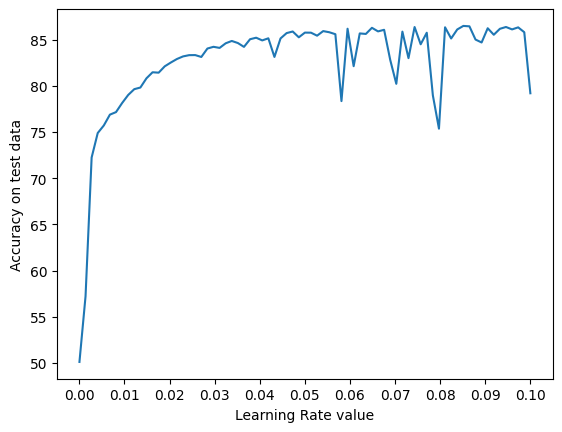

In [ ]:
import matplotlib.pyplot as plt

plt.xlabel("Learning Rate value")
plt.ylabel("Accuracy on test data")
plt.plot(learning_rates, accuracies)
plt.locator_params(axis='both', nbins=15)

plt.show()

In [ ]:
best_ac = accuracies[np.argmax(accuracies)]
best_lr = learning_rates[np.argmax(accuracies)]

print(f"The best learning was {best_lr} with a {best_ac}% accuracy.")

The best learning was 0.06892202702702703 with a 86.34% accuracy.


#### Exercício 3. b)

In [ ]:
optimal_lr = 0.05

### Exercício 4

#### Exercício 4. a)

In [ ]:
import string
from unidecode import unidecode

def normalize_string(s):
    return unidecode(s).strip(string.punctuation).lower()

In [ ]:
# limit the vocabulary size to 20000 most frequent tokens
vocab_size = 20000

counter = Counter()
for (target, line) in list(IMDB(split='train')):
    words = [ normalize_string(word) for word in line.split()]
    counter.update(words)

# create a vocabulary of the 20000 most frequent tokens
most_frequent_words = sorted(counter, key=counter.get, reverse=True)[:vocab_size]
vocab = {word: i for i, word in enumerate(most_frequent_words, 1)}
vocab_size = len(vocab)

In [ ]:
def encode_sentence(sentence, vocab):
    return [ vocab.get(normalize_string(word), 0) for word in sentence.split() ] # 0 for OOV

#### Exercício 4. b)

In [ ]:
# amount of tokens not covered in vocabulary
unknown_tokens = len(counter.items()) - vocab_size

print(f"Amount of unknown (by the vocabulary) tokens in training dataset: {unknown_tokens}")

Amount of unknown (by the vocabulary) tokens in training dataset: 112077


#### Exercício 4. c)

In [ ]:
from torch.nn.functional import one_hot

# Dataset Class with One-hot Encoding
class IMDBDataset(Dataset):
    def __init__(self, split, vocab):
        self.raw_data = list(IMDB(split=split))
        self.vocab = vocab
        self.data = [ self.__encode_sample_to_onehot(sample) for sample in self.raw_data ]

    def __encode_sample_to_onehot(self, sample):
        target, line = sample
        target = 1 if target == 1 else 0
        # one-hot encoding
        X = torch.zeros(len(self.vocab) + 1)
        for word in encode_sentence(line, self.vocab):
            X[word] = 1
        return X, torch.tensor(target)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Load Data with One-hot Encoding
train_data = IMDBDataset('train', vocab)
test_data = IMDBDataset('test', vocab)

## III - Data Loader

In [ ]:
batch_size = 128

# define dataloaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False)

### Exercício 2

#### Exercício 2. a)

In [ ]:
iters = 0
for inputs, targets in train_loader:
    iters += 1
print(f'The train_loader object has {iters} iterations.')

The train_loader object has 196 iterations.


#### Exercício 2. b)

In [ ]:
last_batch_size = 0
for inputs, targets in train_loader:
    last_batch_size = len(inputs)
print(f'Last batch size in the train_loader: {last_batch_size}.')

Last batch size in the train_loader: 40.


#### Exercício 2. c)

In [ ]:
positive_label = 0

Rs = [ ((torch.bincount(targets)[positive_label])/(torch.bincount(targets).sum())).item() for inputs, targets in train_loader ]
R_mean = sum(Rs)/len(Rs)

print(f'Mean R value: {R_mean:.4f}')

Mean R value: 0.5018


#### Exercício 2. d)

In [ ]:
batch = next(iter(train_loader))
inputs, targets = batch

print(f'Inputs tensor:\n\tShape: {inputs.shape}\n\tData Type: {inputs.dtype}')
print()
print(f'Targets tensor:\n\tShape: {targets.shape}\n\tData Type: {targets.dtype}')

Inputs tensor:
	Shape: torch.Size([128, 20001])
	Data Type: torch.float32

Targets tensor:
	Shape: torch.Size([128])
	Data Type: torch.int64


### Exercício 3


#### Exercício 3. a)

In [ ]:
def train_with_batchsize_and_eval(batch_size, device):
    print(f'Evaluating model with Batch Size = {batch_size}:')
    print(f'\tUsing {device} device.')

    # Define dataloaders with argument batch size
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    model = OneHotMLP(vocab_size).to(device)

    # Training
    num_epochs = 5
    criterion = nn.BCEWithLogitsLoss()  # define loss
    optimizer = optim.SGD(model.parameters(), lr=optimal_lr)  # define optimizer

    print(f'\tStarting training for {num_epochs} Epochs.')
    training_start_time = time.time()  # start time of training
    for epoch in range(num_epochs):
        epoch_start_time = time.time()  # Start time of the epoch
        model.train()

        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Forward pass
            logits = model(inputs)
            loss = criterion(logits.squeeze(dim=1), targets.float())
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_end_time = time.time()  # End time of the epoch
        epoch_duration = epoch_end_time - epoch_start_time  # Duration of epoch
        print(f'\t\tEpoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Elapsed Time: {epoch_duration:.2f} sec')

    training_end_time = time.time()  # end time of training
    training_duration = training_end_time - training_start_time  # duration of training
    print('\tFinished training.')
    print(f'\tTraining Time Duration: {training_duration:.2f} sec')


    # Evaluation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            logits = model(inputs)
            predicted = torch.round(torch.sigmoid(logits.squeeze()))
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
        acc = 100*correct/total
        print(f'\tTest accuracy: {acc}%')
        return acc

In [ ]:
import time
import numpy as np

start_time = time.time()  # start time of search for best batch_size

batch_sizes = [1, 128, 512]
accuracies = []
for batch_size in batch_sizes:
    ac = train_with_batchsize_and_eval(batch_size, device)
    accuracies.append(ac)

end_time = time.time()  # end time of search for best batch_size
search_duration = end_time - start_time  # duration of search for best batch_size

print()
print(f'Evaluation of {len(batch_sizes)} Batch Sizes took {search_duration:.2f} sec')

Evaluating model with Batch Size = 1:
	Using cuda device.
	Starting training for 5 Epochs.
		Epoch [1/5], Loss: 0.0147, Elapsed Time: 32.88 sec
		Epoch [2/5], Loss: 0.0854, Elapsed Time: 32.89 sec
		Epoch [3/5], Loss: 0.0008, Elapsed Time: 33.28 sec
		Epoch [4/5], Loss: 0.0001, Elapsed Time: 32.83 sec
		Epoch [5/5], Loss: 0.0053, Elapsed Time: 32.61 sec
	Finished training.
	Training Time Duration: 164.49 sec
	Test accuracy: 85.936%
Evaluating model with Batch Size = 128:
	Using cuda device.
	Starting training for 5 Epochs.
		Epoch [1/5], Loss: 0.4746, Elapsed Time: 1.02 sec
		Epoch [2/5], Loss: 0.4099, Elapsed Time: 1.08 sec
		Epoch [3/5], Loss: 0.1984, Elapsed Time: 1.11 sec
		Epoch [4/5], Loss: 0.2441, Elapsed Time: 1.00 sec
		Epoch [5/5], Loss: 0.2773, Elapsed Time: 0.98 sec
	Finished training.
	Training Time Duration: 5.20 sec
	Test accuracy: 87.984%
Evaluating model with Batch Size = 512:
	Using cuda device.
	Starting training for 5 Epochs.
		Epoch [1/5], Loss: 0.6717, Elapsed Tim

## IV - Modelo

In [ ]:
class OneHotMLP(nn.Module):
    def __init__(self, vocab_size):
        super(OneHotMLP, self).__init__()

        self.fc1 = nn.Linear(vocab_size+1, 200)
        self.fc2 = nn.Linear(200, 1)

        self.relu = nn.ReLU()

    def forward(self, x):
        o = self.fc1(x.float())
        o = self.relu(o)
        return self.fc2(o)

# Model instantiation
model = OneHotMLP(vocab_size)

### Exercício 1

#### Exercício 1. a)

Mean value of predicted probabilities:	0.5051
Min value of predicted probabilities:	0.4962
Max value of predicted probabilities:	0.5154
Standard deviation of predicted probabilities:	0.0034


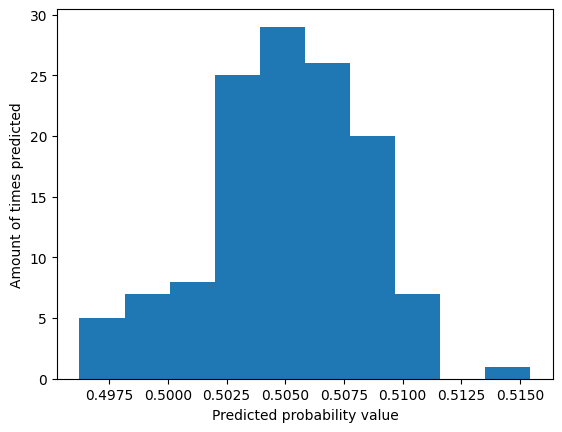

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Model instantiation
model = OneHotMLP(vocab_size)
model = model.to(device)

inputs, targets = next(iter(train_loader))

# loads tensors into device
inputs = inputs.to(device)
targets = targets.to(device)

logits = model(inputs)
probs = torch.sigmoid(logits.squeeze(dim=1))

print(f'Mean value of predicted probabilities:\t{torch.mean(probs):.4f}')
print(f'Min value of predicted probabilities:\t{torch.min(probs):.4f}')
print(f'Max value of predicted probabilities:\t{torch.max(probs):.4f}')
print(f'Standard deviation of predicted probabilities:\t{torch.std(probs):.4f}')

plt.xlabel("Predicted probability value")
plt.ylabel("Amount of times predicted")
plt.hist(probs.detach().cpu().numpy())
plt.show()

#### Exercício 1. b)

Epoch [1/5],             Loss: 0.4715,             Elapsed Time: 1.00 sec
Epoch [2/5],             Loss: 0.3208,             Elapsed Time: 1.01 sec
Epoch [3/5],             Loss: 0.3131,             Elapsed Time: 1.23 sec
Epoch [4/5],             Loss: 0.2404,             Elapsed Time: 1.18 sec
Epoch [5/5],             Loss: 0.3679,             Elapsed Time: 1.10 sec
Mean value of predicted probabilities:	0.4138
Min value of predicted probabilities:	0.0000
Max value of predicted probabilities:	0.9979
Standard deviation of predicted probabilities:	0.3660


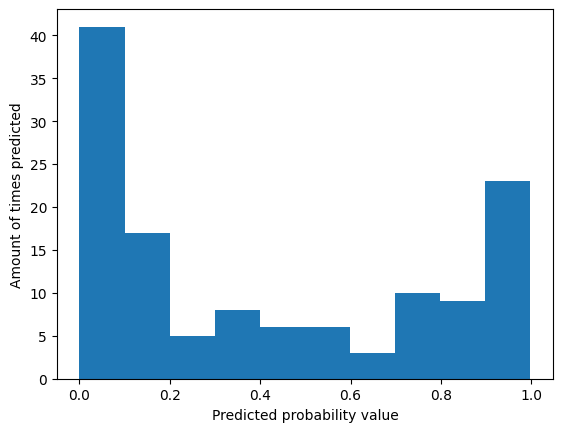

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np

# Model instantiation
model = OneHotMLP(vocab_size)
model = model.to(device)

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=optimal_lr)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    start_time = time.time()  # Start time of the epoch
    model.train()
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Forward pass
        logits = model(inputs)
        loss = criterion(logits.squeeze(), targets.float())
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    end_time = time.time()  # End time of the epoch
    epoch_duration = end_time - start_time  # Duration of epoch

    print(f'Epoch [{epoch+1}/{num_epochs}], \
            Loss: {loss.item():.4f}, \
            Elapsed Time: {epoch_duration:.2f} sec')

# Evaluate model on firs tbatch of training data
inputs, targets = next(iter(train_loader))

# loads tensors into device
inputs = inputs.to(device)
targets = targets.to(device)

logits = model(inputs)
probs = torch.sigmoid(logits.squeeze(dim=1))
predicted = torch.round(probs)

total = targets.size(0)
correct = (predicted == targets).sum().item()

print(f'Mean value of predicted probabilities:\t{torch.mean(probs):.4f}')
print(f'Min value of predicted probabilities:\t{torch.min(probs):.4f}')
print(f'Max value of predicted probabilities:\t{torch.max(probs):.4f}')
print(f'Standard deviation of predicted probabilities:\t{torch.std(probs):.4f}')

plt.xlabel("Predicted probability value")
plt.ylabel("Amount of times predicted")
plt.hist(probs.detach().cpu().numpy())
plt.show()

#### Exercício 1. c)

In [ ]:
print('Model Summary:')
print(model)

Model Summary:
OneHotMLP(
  (fc1): Linear(in_features=20001, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=1, bias=True)
  (relu): ReLU()
)


In [ ]:
fc1_w_shape = model.fc1.weight.shape
fc1_b_shape = model.fc1.bias.shape
fc2_w_shape = model.fc2.weight.shape
fc2_b_shape = model.fc2.bias.shape

print('Model parameters:')

print('\tFirst FC Layer:')
print(f'\t\tWeights tensor shape: {fc1_w_shape}')
print(f'\t\tNumber of weights: {fc1_w_shape[0]*fc1_w_shape[1]}')
print(f'\t\tBias tensor shape: {fc1_b_shape}')
print(f'\t\tNumber of biases: {fc1_b_shape[0]}')

print('\tSecond FC Layer:')
print(f'\t\tWeights tensor shape: {fc2_w_shape}')
print(f'\t\tNumber of weights: {fc2_w_shape[0]*fc2_w_shape[1]}')
print(f'\t\tBias tensor shape: {fc1_b_shape}')
print(f'\t\tNumber of biases: {fc2_b_shape[0]}')

print(f'\tTotal number of parameters: {fc1_w_shape[0]*fc1_w_shape[1] + fc2_w_shape[0]*fc2_w_shape[1] + fc1_b_shape[0] + fc2_b_shape[0]}')

Model parameters:
	First FC Layer:
		Weights tensor shape: torch.Size([200, 20001])
		Number of weights: 4000200
		Bias tensor shape: torch.Size([200])
		Number of biases: 200
	Second FC Layer:
		Weights tensor shape: torch.Size([1, 200])
		Number of weights: 200
		Bias tensor shape: torch.Size([200])
		Number of biases: 1
	Total number of parameters: 4000601


## V - Laço de Treinamento - Otimização da função de Perda pelo Gradiente descendente

In [ ]:
# Verifica se há uma GPU disponível e define o dispositivo para GPU se possível, caso contrário, usa a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print('GPU:', torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print('using CPU')

GPU: Tesla T4


In [ ]:
import time

model = model.to(device)
# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=optimal_lr)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    start_time = time.time()  # Start time of the epoch
    model.train()
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Forward pass
        logits = model(inputs)
        loss = criterion(logits.squeeze(), targets.float())
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    end_time = time.time()  # End time of the epoch
    epoch_duration = end_time - start_time  # Duration of epoch

    print(f'Epoch [{epoch+1}/{num_epochs}], \
            Loss: {loss.item():.4f}, \
            Elapsed Time: {epoch_duration:.2f} sec')

Epoch [1/5],             Loss: 0.1970,             Elapsed Time: 1.02 sec
Epoch [2/5],             Loss: 0.2265,             Elapsed Time: 1.02 sec
Epoch [3/5],             Loss: 0.3057,             Elapsed Time: 1.03 sec
Epoch [4/5],             Loss: 0.1099,             Elapsed Time: 1.04 sec
Epoch [5/5],             Loss: 0.2830,             Elapsed Time: 1.02 sec


### Exercício 1

#### Exercício 1. b)

In [ ]:
# Instantiate new model
model = OneHotMLP(vocab_size)
model.to(device)

inputs, targets = next(iter(train_loader))

# loads tensors into device
inputs = inputs.to(device)
targets = targets.to(device)

logits = model(inputs)
probs = torch.sigmoid(logits.squeeze(dim=1))

In [ ]:
def bce_loss(y_prob, y_target):
    return - ( torch.mul( y_target, torch.log(y_prob) ) + torch.mul( (1-y_target), torch.log(1-y_prob) ) ).mean().item()

print(f'Implemented bce_loss value:\t{bce_loss(probs, targets.float())}')

Implemented bce_loss value:	0.6936115026473999


#### Exercício 1. c)

In [ ]:
BCE_loss = nn.BCELoss()
print(f'PyTorch nn.BCELoss value:\t{BCE_loss(probs, targets.float())}')

PyTorch nn.BCELoss value:	0.6930720210075378


#### Exercício 1. d)

In [ ]:
def bce_with_logits_loss(y_logits, y_target):
    y_prob = 1 / (1 + torch.exp(-y_logits))
    return - ( torch.mul( y_target, torch.log(y_prob) ) + torch.mul( (1-y_target), torch.log(1-y_prob) ) ).mean().item()

print(f'Implemented bce_with_logits_loss value:\t{bce_with_logits_loss(logits.squeeze(dim=1), targets.float())}')

BCELogits_loss = nn.BCEWithLogitsLoss()
print(f'PyTorch nn.BCEWithLogitsLoss value:\t{BCELogits_loss(logits.squeeze(dim=1), targets.float())}')

Implemented bce_with_logits_loss value:	0.6936115026473999
PyTorch nn.BCEWithLogitsLoss value:	0.6936114430427551


### Exercício 2

#### Exercício 2. a)

In [ ]:
import time

# Instantiate new model
model = OneHotMLP(vocab_size)
model = model.to(device)

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=optimal_lr)

# Evaluate loss before training
with torch.no_grad():
    initial_losses = []
    model.eval()
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        logits = model(inputs)
        initial_losses.append(criterion(logits.squeeze(), targets.float()))
    initial_loss = sum(initial_losses)/len(initial_losses)
    print(f'Loss on training data before starting training: {initial_loss:.4f}')

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    start_time = time.time()  # Start time of the epoch
    model.train()
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Forward pass
        logits = model(inputs)
        loss = criterion(logits.squeeze(), targets.float())
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    end_time = time.time()  # End time of the epoch
    epoch_duration = end_time - start_time  # Duration of epoch

    print(f'Epoch [{epoch+1}/{num_epochs}], \
            Loss: {loss.item():.4f}, \
            Elapsed Time: {epoch_duration:.2f} sec')

Loss on training data before starting training: 0.6938
Epoch [1/5],             Loss: 0.5262,             Elapsed Time: 1.09 sec
Epoch [2/5],             Loss: 0.3396,             Elapsed Time: 1.02 sec
Epoch [3/5],             Loss: 0.3165,             Elapsed Time: 1.03 sec
Epoch [4/5],             Loss: 0.4031,             Elapsed Time: 1.11 sec
Epoch [5/5],             Loss: 0.2710,             Elapsed Time: 1.18 sec


## VI - Avaliação

In [ ]:
## evaluation
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        logits = model(inputs)
        predicted = torch.round(torch.sigmoid(logits.squeeze()))
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    print(f'Test Accuracy: {100 * correct / total}%')

Test Accuracy: 87.364%


### Exercício 1

#### Exercício 1. a)

In [ ]:
samples = 0
for inputs, targets in test_loader:
    samples += len(targets)
print(f'Number of samples on test data: {samples}')

Number of samples on test data: 25000


#### Exercício 1. c)

In [ ]:
# Evaluation with using torch.sigmoid function

model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        logits = model(inputs)
        predicted = torch.tensor([ 1 if logit >= 0 else 0 for logit in logits.squeeze(dim=1) ]).to(device)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    print(f'Test Accuracy: {100 * correct / total}%')

Test Accuracy: 87.364%


### Exercício 3

#### Exercício 3. a)

In [ ]:
# Evaluation printing Accuracy, Loss and Perplexity

model.eval()

with torch.no_grad():
    losses = []
    correct = 0
    total = 0
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        logits = model(inputs)
        losses.append(bce_loss(torch.sigmoid(logits.squeeze(dim=1)), targets.float()))
        predicted = torch.round(torch.sigmoid(logits.squeeze(dim=1)))
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    accuracy = 100 * correct/total
    loss = torch.tensor(losses).mean()
    PPL = torch.exp(loss)

    print(f'Accuracy on test data:\t{accuracy}%.')
    print(f'Loss on test data:\t{loss}.')
    print(f'Perplexity on test data:\t{PPL}.')

Accuracy on test data:	87.364%.
Loss on test data:	0.3059355914592743.
Perplexity on test data:	1.3578948974609375.


#### Exercício 3. b)

In [ ]:
# Training loop with inital loss and perplexity during training

import time

# Instantiate new model
model = OneHotMLP(vocab_size)
model = model.to(device)

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=optimal_lr)

# Evaluate loss before training
with torch.no_grad():
    initial_losses = []
    model.eval()
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        logits = model(inputs)
        initial_losses.append(criterion(logits.squeeze(), targets.float()))
    initial_loss = torch.tensor(initial_losses).mean()
    initial_PPL = torch.exp(initial_loss)
    print(f'Loss on training data before starting training:\t{initial_loss:.4f}')
    print(f'Perplexity on training data before starting training:\t{initial_loss:.4f}')

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    start_time = time.time()  # Start time of the epoch
    model.train()
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Forward pass
        logits = model(inputs)
        loss = criterion(logits.squeeze(), targets.float())
        PPL = torch.exp(loss)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    end_time = time.time()  # End time of the epoch
    epoch_duration = end_time - start_time  # Duration of epoch

    print(f'Epoch [{epoch+1}/{num_epochs}], \
            Loss: {loss.item():.4f}, \
            Perplexity: {PPL.item():.4f}, \
            Elapsed Time: {epoch_duration:.2f} sec')

Loss on training data before starting training:	0.6936
Perplexity on training data before starting training:	0.6936
Epoch [1/5],             Loss: 0.5463,             Perplexity: 1.7268,             Elapsed Time: 1.05 sec
Epoch [2/5],             Loss: 0.3439,             Perplexity: 1.4104,             Elapsed Time: 1.18 sec
Epoch [3/5],             Loss: 0.2785,             Perplexity: 1.3212,             Elapsed Time: 1.14 sec
Epoch [4/5],             Loss: 0.2770,             Perplexity: 1.3192,             Elapsed Time: 1.07 sec
Epoch [5/5],             Loss: 0.1571,             Perplexity: 1.1701,             Elapsed Time: 1.02 sec


In [ ]:
# Evaluation printing Accuracy, Loss and Perplexity

model.eval()

with torch.no_grad():
    losses = []
    correct = 0
    total = 0
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        logits = model(inputs)
        losses.append(bce_loss(torch.sigmoid(logits.squeeze(dim=1)), targets.float()))
        predicted = torch.round(torch.sigmoid(logits.squeeze(dim=1)))
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    accuracy = 100 * correct/total
    loss = torch.tensor(losses).mean()
    PPL = torch.exp(loss)

    print(f'Accuracy on test data:\t{accuracy}%.')
    print(f'Loss on test data:\t{loss}.')
    print(f'Perplexity on test data:\t{PPL}.')

Accuracy on test data:	87.908%.
Loss on test data:	0.2965632975101471.
Perplexity on test data:	1.3452277183532715.
